# Combatting Partisan Homogenization in New Content Recommenders - Baselines(BERT)

In [8]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [11]:
from general_utils import timer

from config import RANDOM_SEED

from bert_utils import load_bert_output

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

In [12]:
warnings.filterwarnings('ignore')

In [13]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4321 mins


Finished running 'sample_data' in 0.0018 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3162 mins

First Ten Files : ['/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/0.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/1.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/2.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/3.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_ou

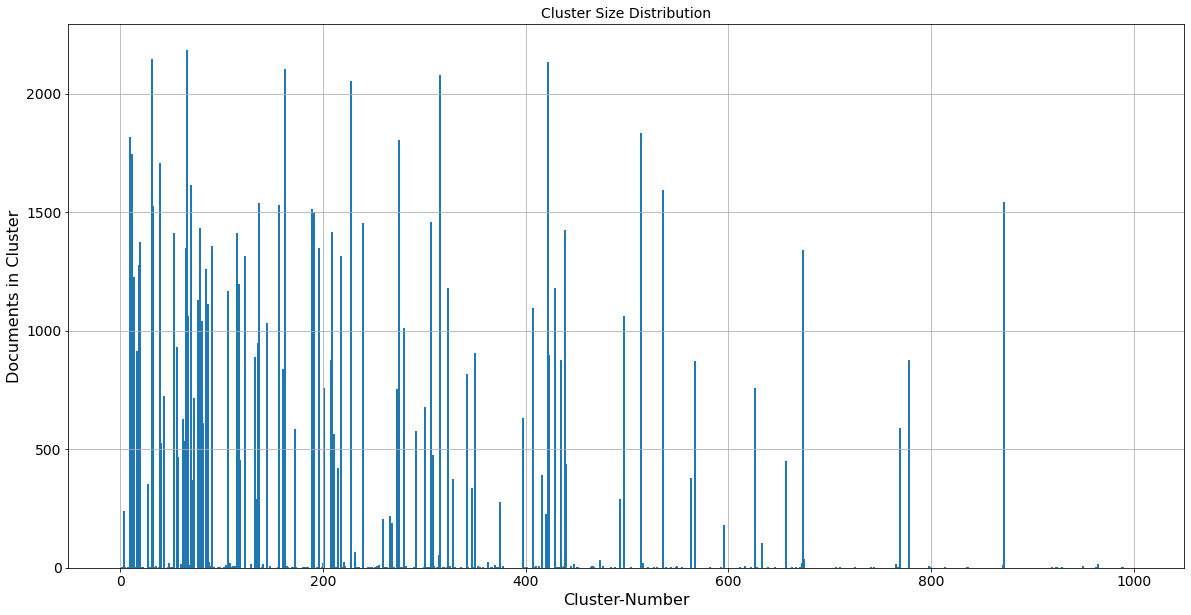


Finished running 'get_pairwise_dist' in 0.0002 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0007 mins

499500


In [14]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

reduced_vectors =  load_bert_output(folder1="/media/karthikshivaram/Extra_disk_1/Bert_model_outputs",
                              folder2="/media/karthikshivaram/Extra_Disk_2/Bert_model_outputs",
                              layer=2,aggregation="mean + max")

print("Bert Embedding Output Shape : %s" %str(reduced_vectors.shape))

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [15]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0005 mins



In [16]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0922 mins

Filtered CLustered Pairs : 820


In [17]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [18]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.1927 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0993 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.4381 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0764 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.1627 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.2092 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.1231 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.2214 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1648 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0180 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.1060 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.1700 mins

Training model

In [19]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.1731 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.1191 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.4621 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0681 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.1751 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.1927 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.1210 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.2100 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1745 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0199 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.1340 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.1822 mins

Training model

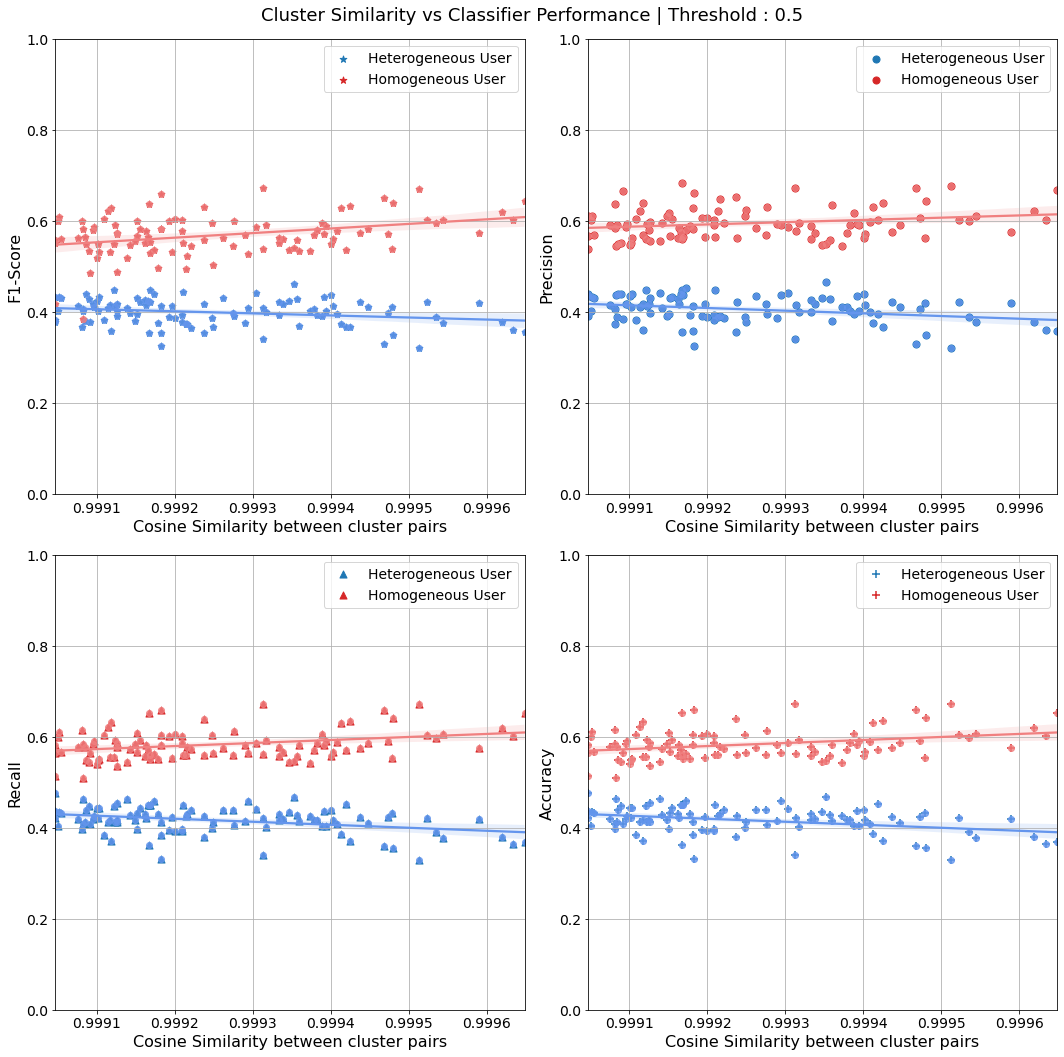


Finished running 'bsl1_sim_vs_score_all_users' in 0.0210 mins



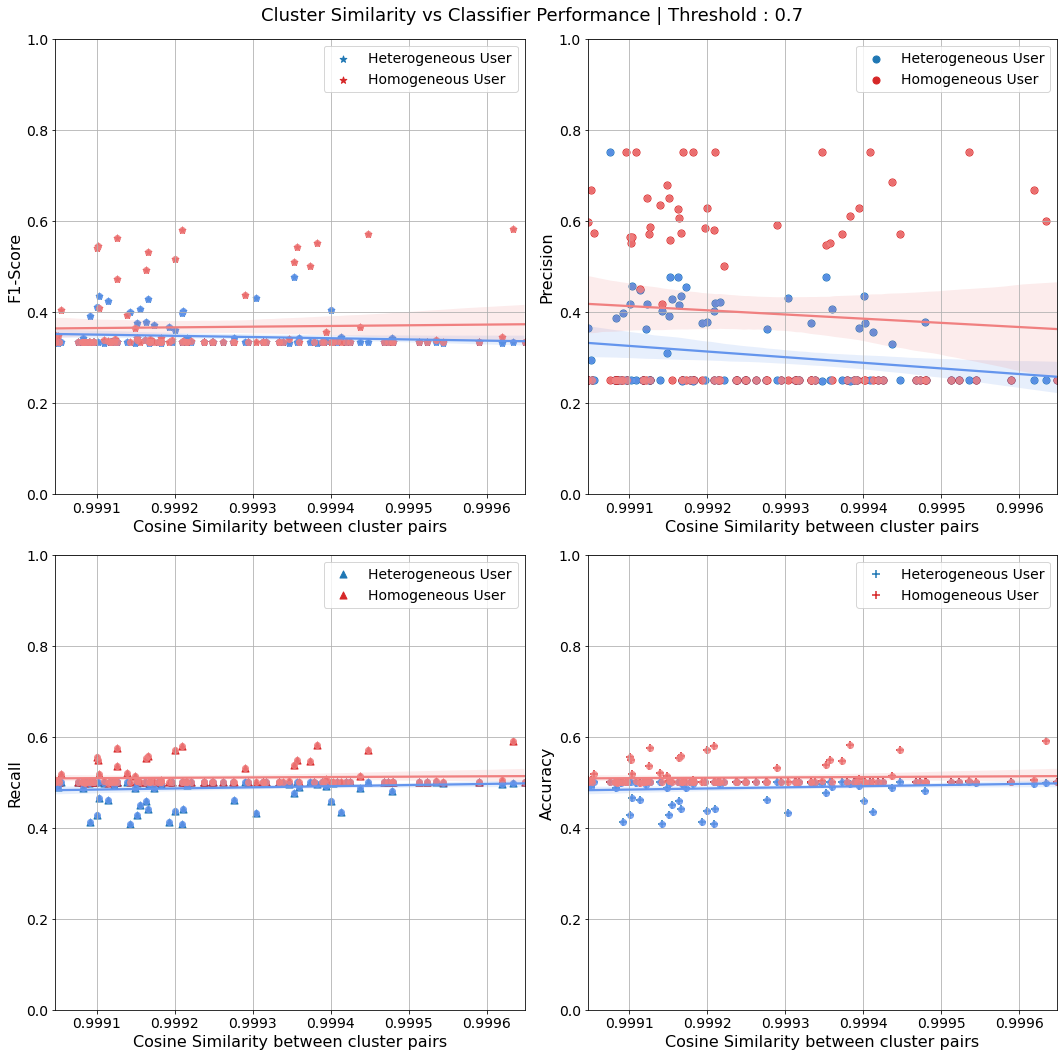


Finished running 'bsl1_sim_vs_score_all_users' in 0.0217 mins



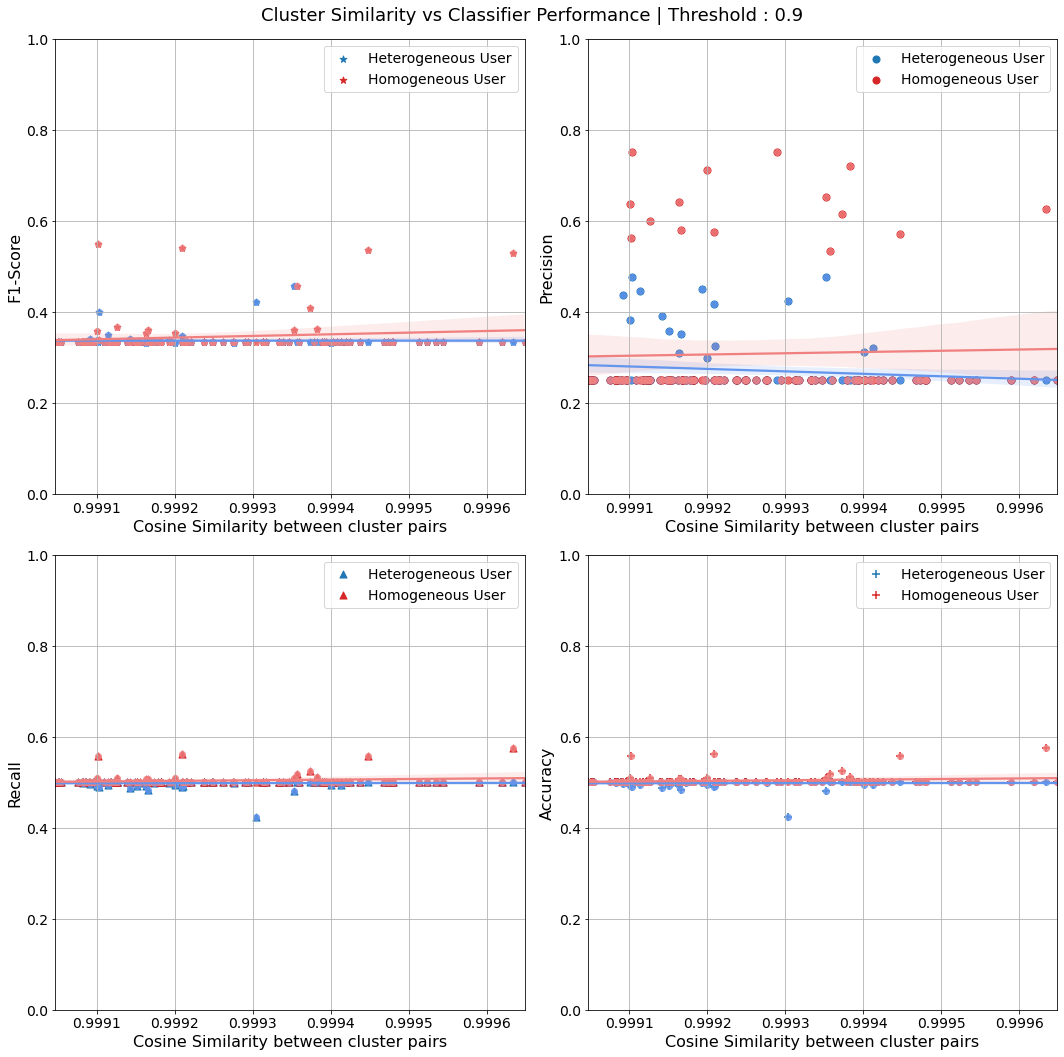


Finished running 'bsl1_sim_vs_score_all_users' in 0.0208 mins



In [20]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [21]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (137, 228)
Training model for cluster pair : (19, 87)
Training model for cluster pair : (66, 87)
Training model for cluster pair : (87, 228)
Training model for cluster pair : (209, 514)
Training model for cluster pair : (12, 40)
Training model for cluster pair : (19, 567)
Training model for cluster pair : (189, 778)
Training model for cluster pair : (196, 280)
Training model for cluster pair : (40, 87)
Training model for cluster pair : (53, 323)
Training model for cluster pair : (137, 439)
Training model for cluster pair : (19, 40)
Training model for cluster pair : (240, 514)
Training model for cluster pair : (77, 567)
Training model for cluster pair : (145, 769)
Training model for cluster pair : (53, 422)
Training model for cluster pair : (87, 137)
Training model for cluster pair : (123, 209)
Training model for cluster pair : (19, 66)
Training model for cluster pair : (32, 145)
Training model for cluster pair : (208, 626)
Training model for cluster pa

In [22]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (137, 228)
Training model for cluster pair : (19, 87)
Training model for cluster pair : (66, 87)
Training model for cluster pair : (87, 228)
Training model for cluster pair : (209, 514)
Training model for cluster pair : (12, 40)
Training model for cluster pair : (19, 567)
Training model for cluster pair : (189, 778)
Training model for cluster pair : (196, 280)
Training model for cluster pair : (40, 87)
Training model for cluster pair : (53, 323)
Training model for cluster pair : (137, 439)
Training model for cluster pair : (19, 40)
Training model for cluster pair : (240, 514)
Training model for cluster pair : (77, 567)
Training model for cluster pair : (145, 769)
Training model for cluster pair : (53, 422)
Training model for cluster pair : (87, 137)
Training model for cluster pair : (123, 209)
Training model for cluster pair : (19, 66)
Training model for cluster pair : (32, 145)
Training model for cluster pair : (208, 626)
Training model for cluster pa


Finished running 'combine_scores_cumu_online_setting' in 0.0001 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0001 mins



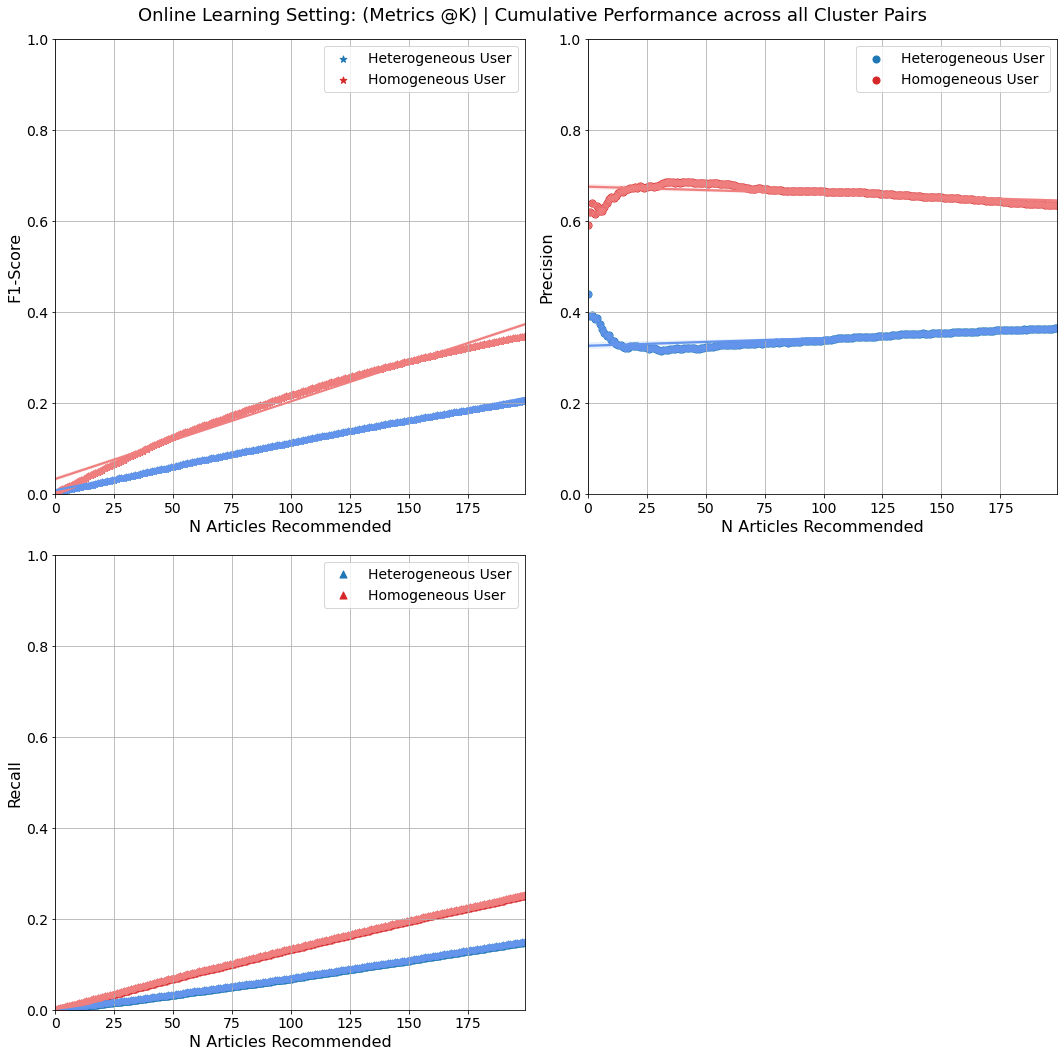


Finished running 'plot_online_setting_per_clusterpair' in 0.0184 mins


Finished running 'plot_online_learning_cumulative' in 0.0186 mins



In [23]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

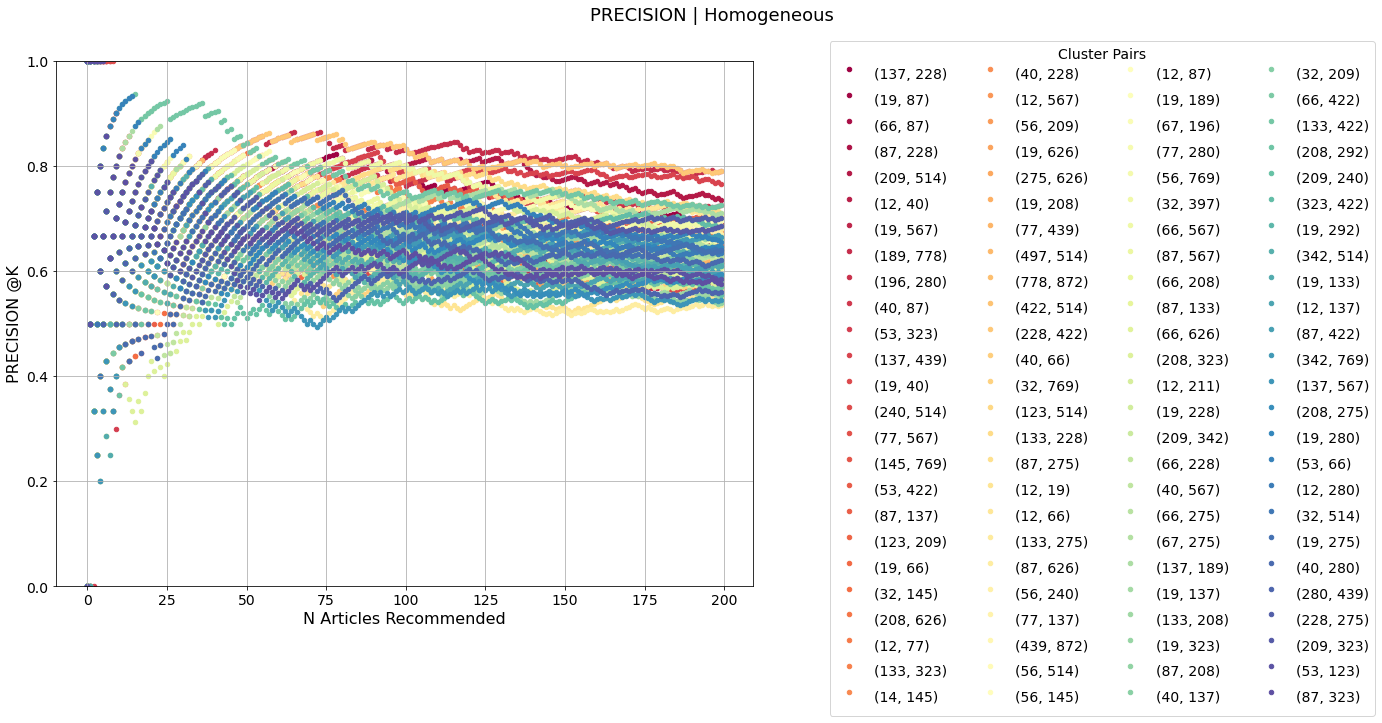


Finished running 'plot_all_cp_online' in 0.0629 mins



In [24]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

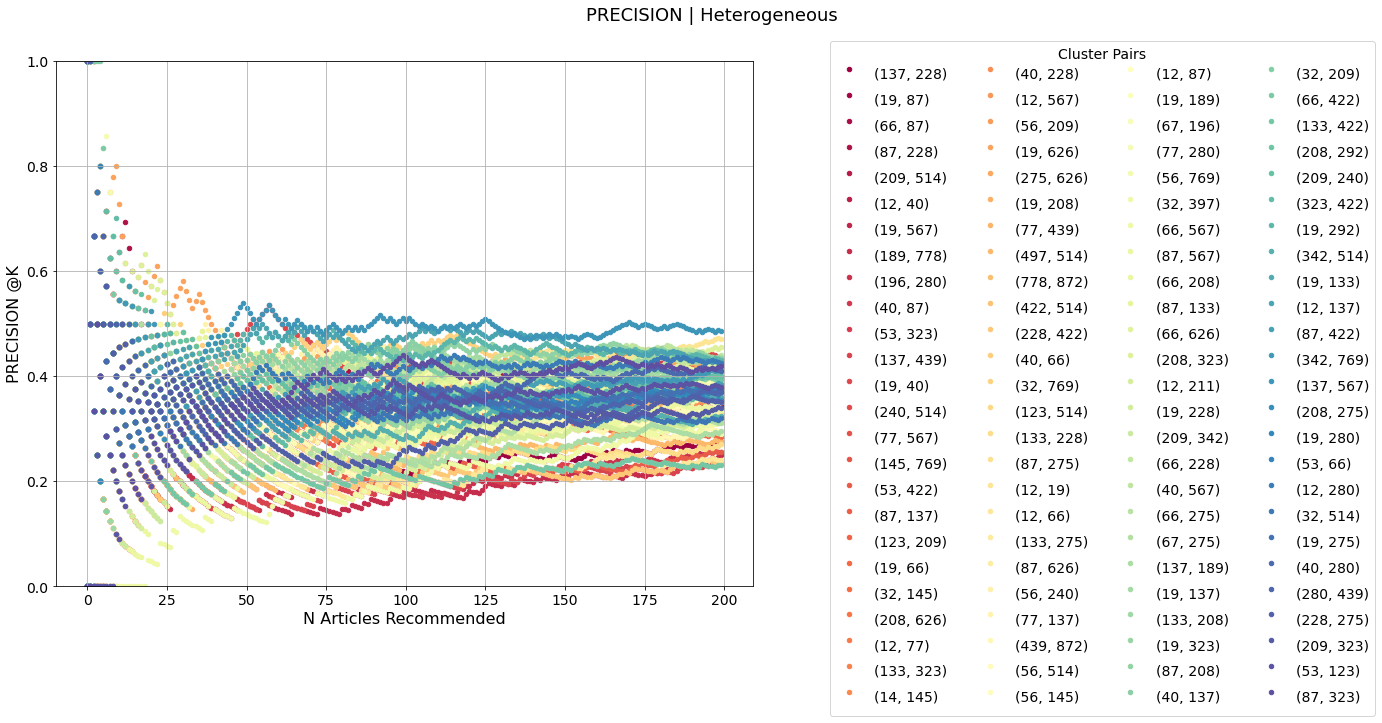


Finished running 'plot_all_cp_online' in 0.0603 mins



In [25]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [26]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [27]:
np.mean(avg_presc_homo)

0.6597649976149833

In [28]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [29]:
np.mean(avg_presc_hetero)

0.3422261441923841

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [30]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [31]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



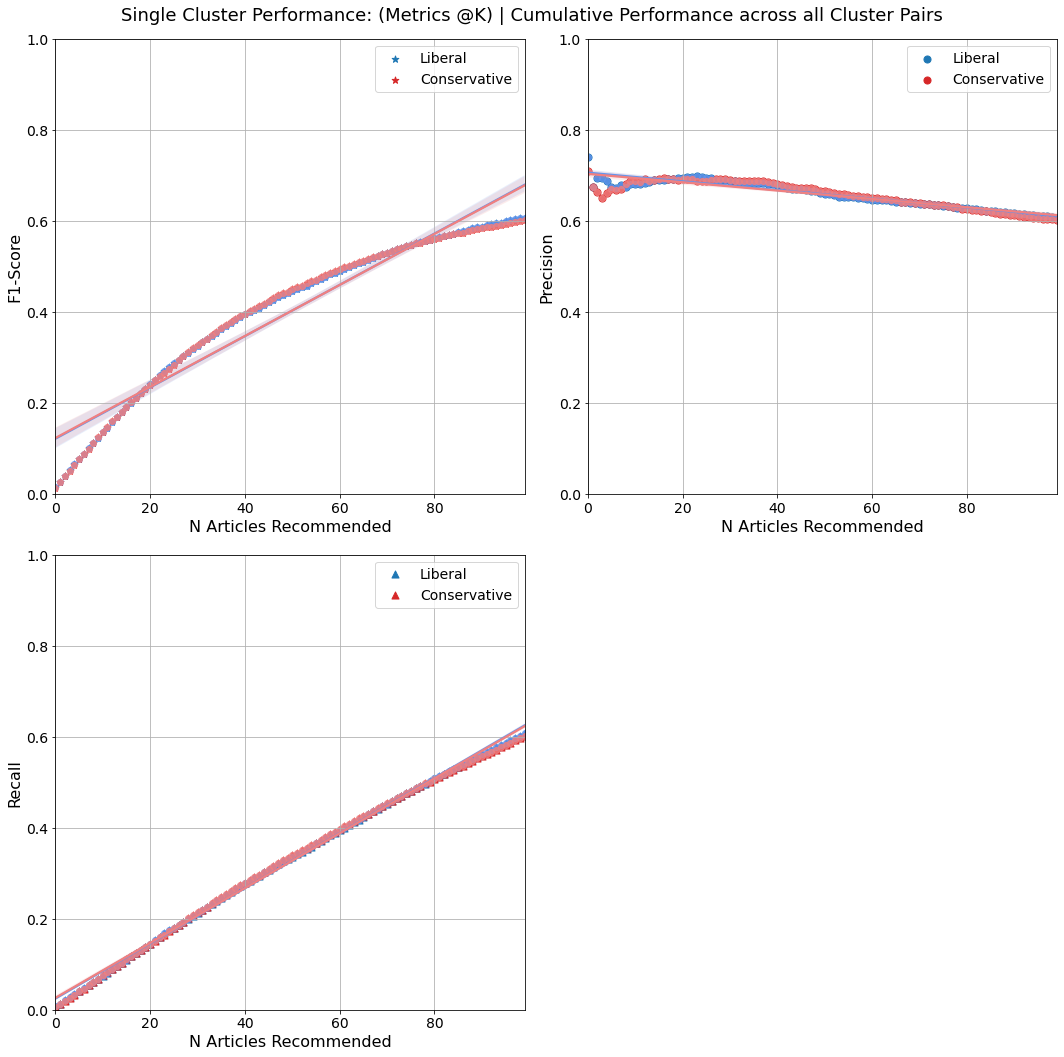


Finished running 'plot_single_cluster_performance' in 0.0167 mins


Finished running 'plot_single_cluster_cumulative' in 0.0168 mins



In [32]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

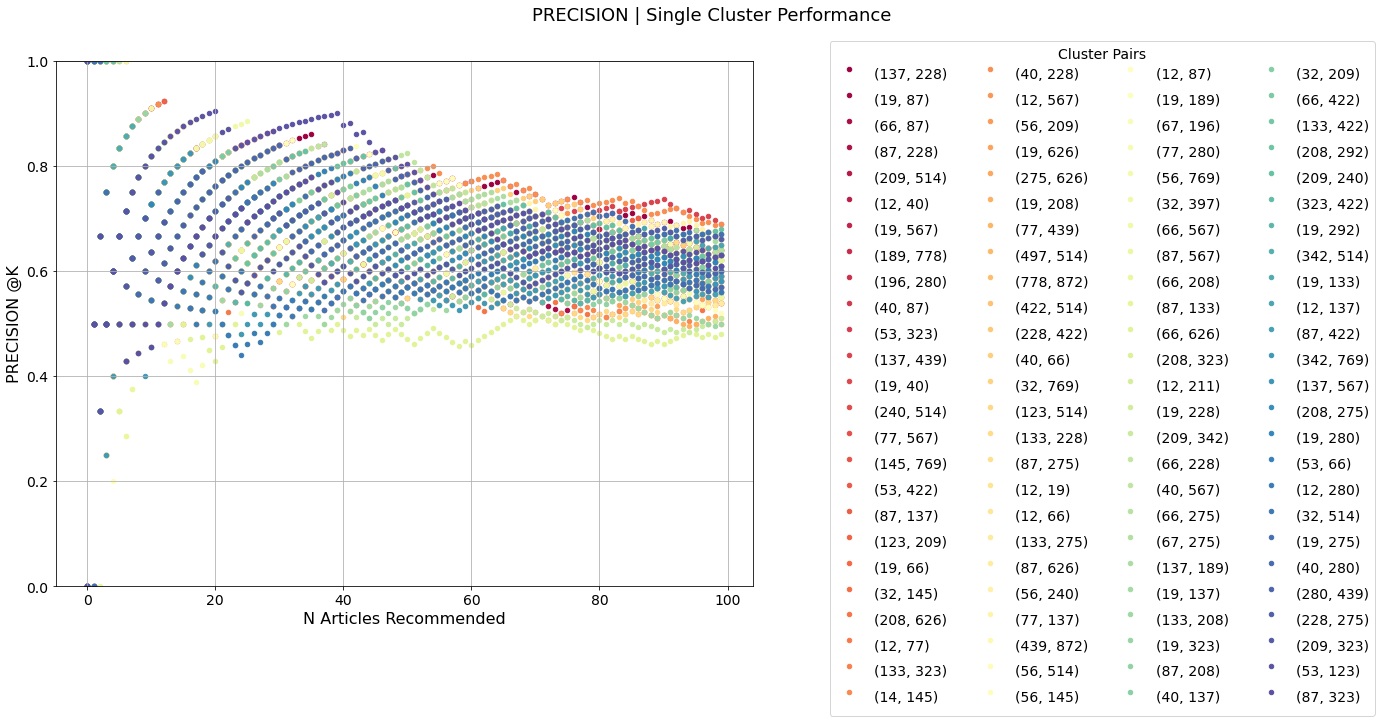


Finished running 'plot_all_cp_singlecluster' in 0.0576 mins



In [33]:
plot_all_cp_singlecluster(homo_scores)

In [34]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [35]:
np.mean(avg_presc_homo)

0.6576708048049137

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [36]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [37]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



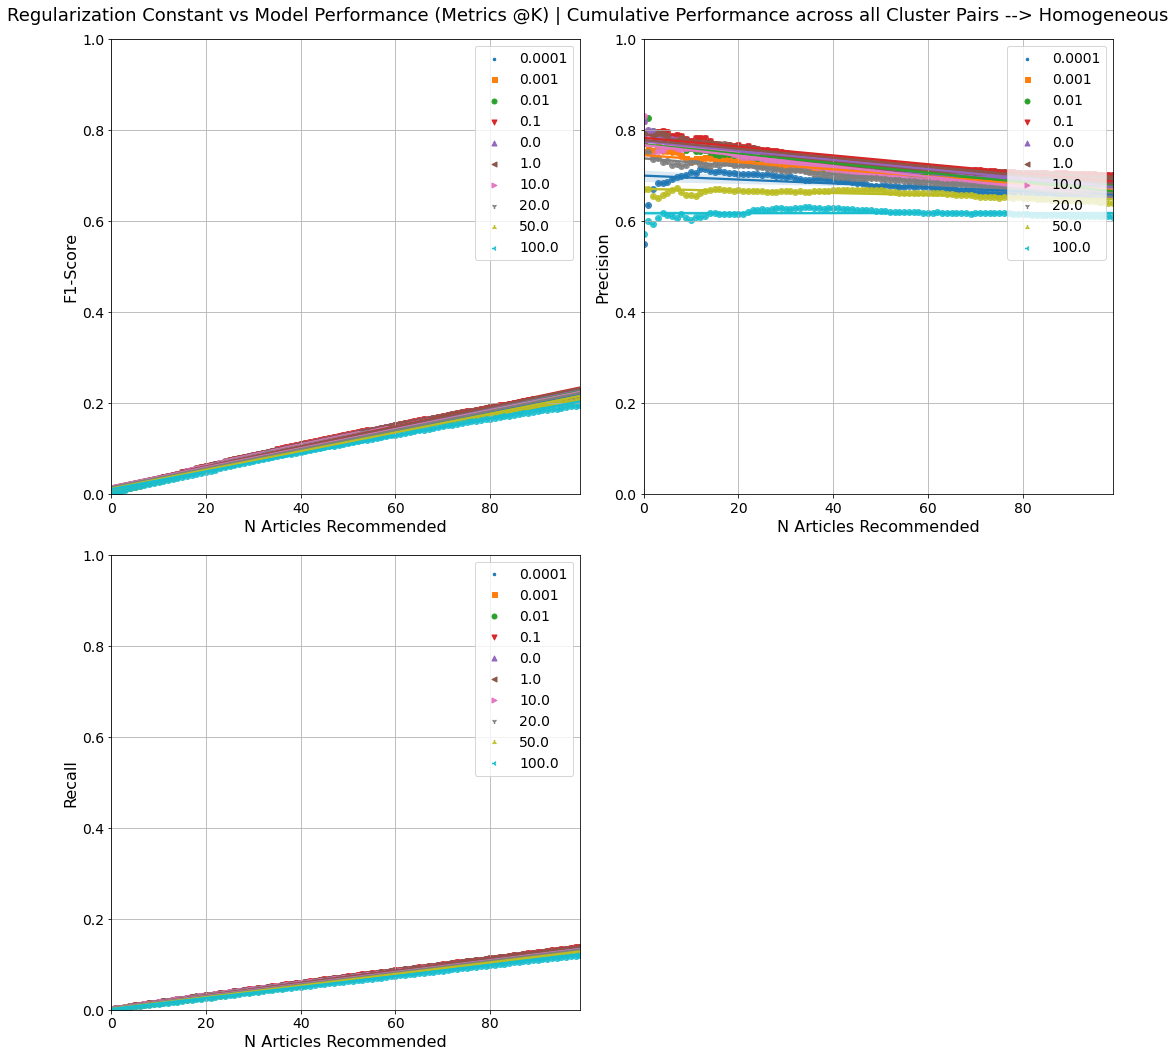


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0575 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0578 mins



In [38]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



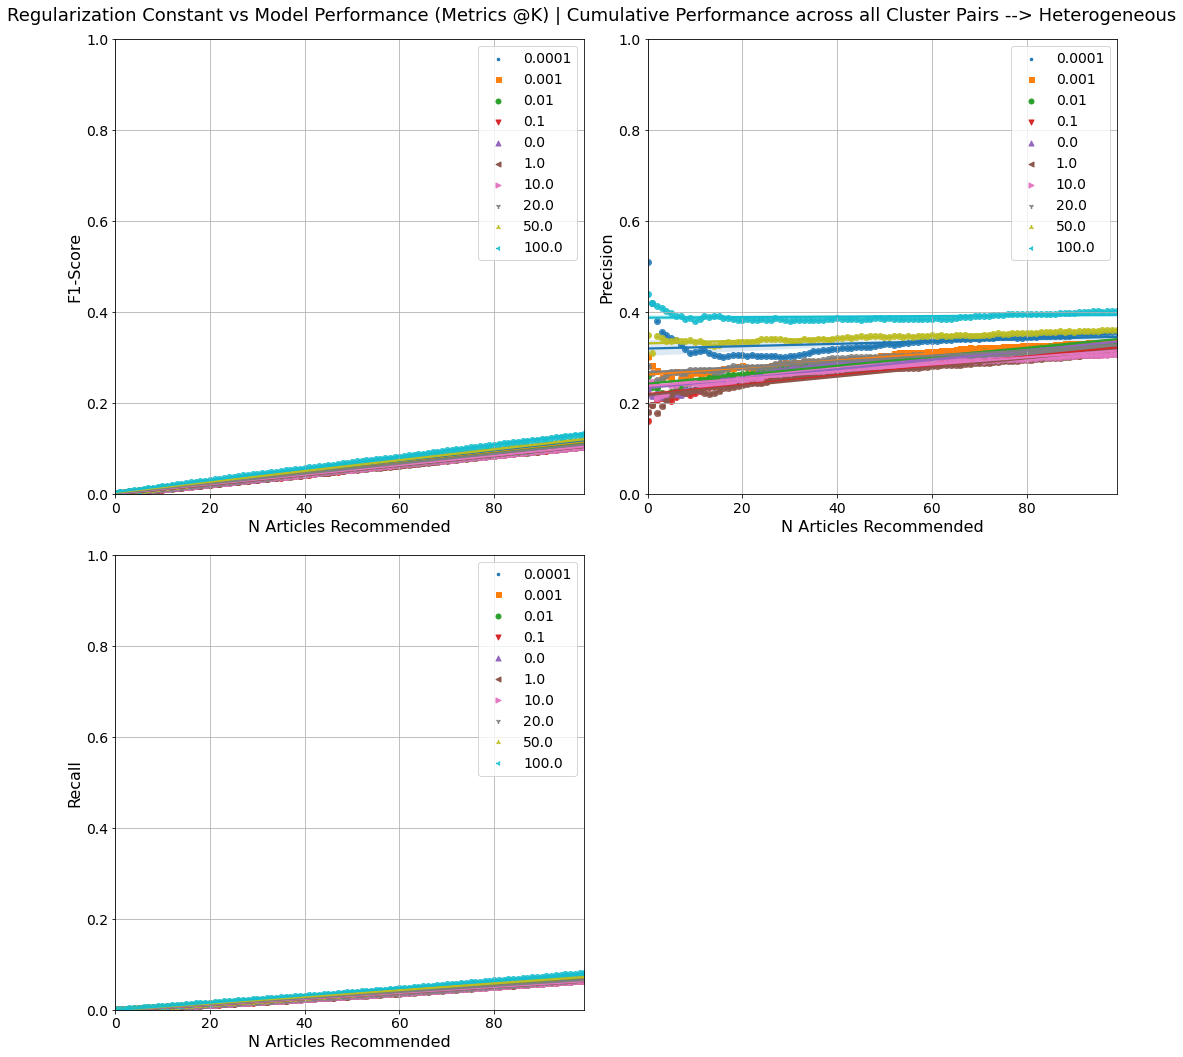


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0601 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0605 mins



In [39]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [40]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [41]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6778847365532069

Param : 0.001
0.7056132205972844

Param : 0.01
0.716423342603386

Param : 0.1
0.7343421230871137

Param : 0.0
0.7241475460847372

Param : 1.0
0.7295371061721716

Param : 10.0
0.7089904861494789

Param : 20.0
0.6948556390027456

Param : 50.0
0.6587319292144801

Param : 100.0
0.6167650694928529


In [42]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [43]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.3321750711779975

Param : 0.001
0.300356803216594

Param : 0.01
0.291010006935023

Param : 0.1
0.2702558732646747

Param : 0.0
0.2836571271617631

Param : 1.0
0.26721578568048787

Param : 10.0
0.27609693001949454

Param : 20.0
0.29693798643121533

Param : 50.0
0.34472720183753613

Param : 100.0
0.39005436824943807


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [44]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (137, 228) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (137, 228) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (137, 228) , LR = 20 *****

In [45]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (137, 228) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (137, 228) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (137, 228) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (137, 228) , LR = 20 *****


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



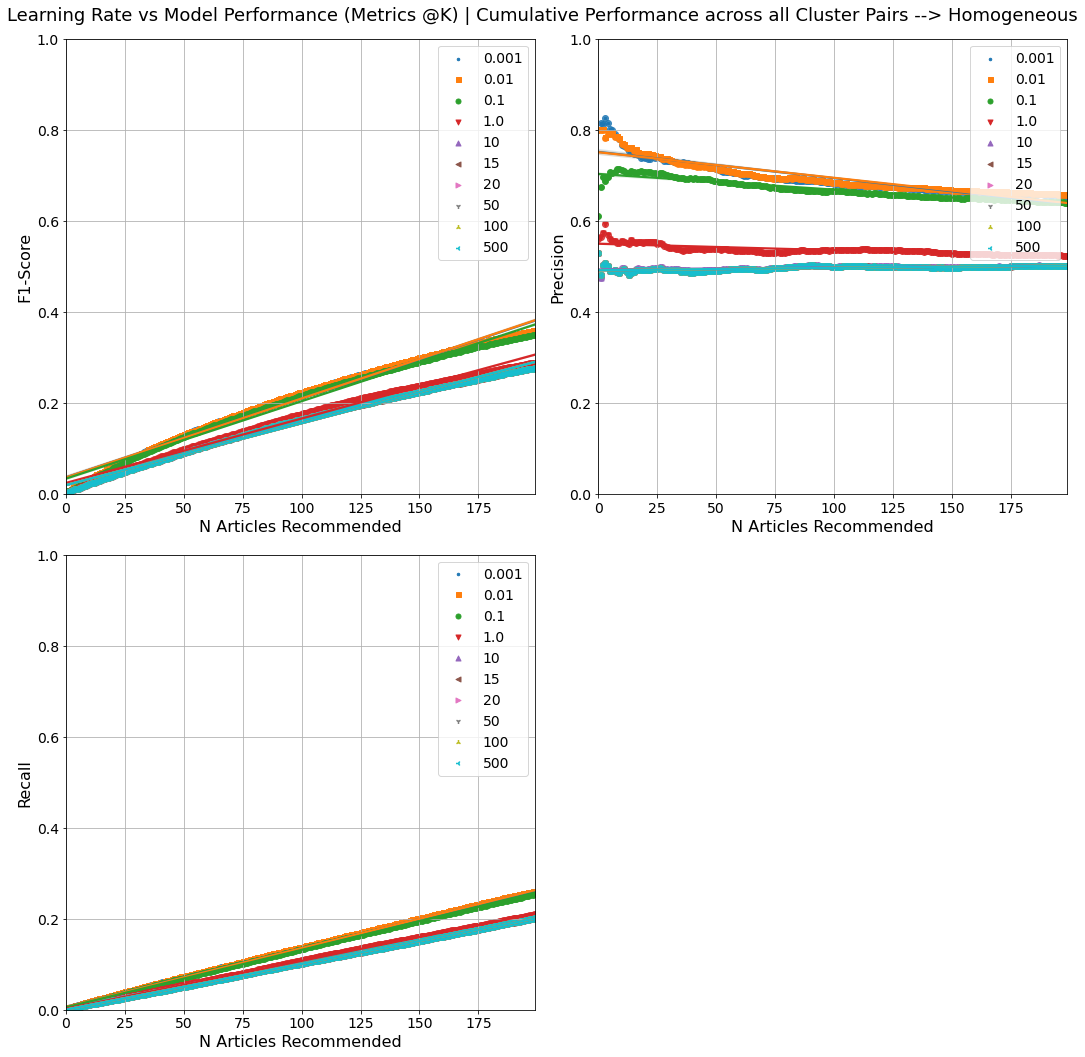


Finished running 'plot_lr_vs_metrics_at_k' in 0.0658 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0665 mins



In [46]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



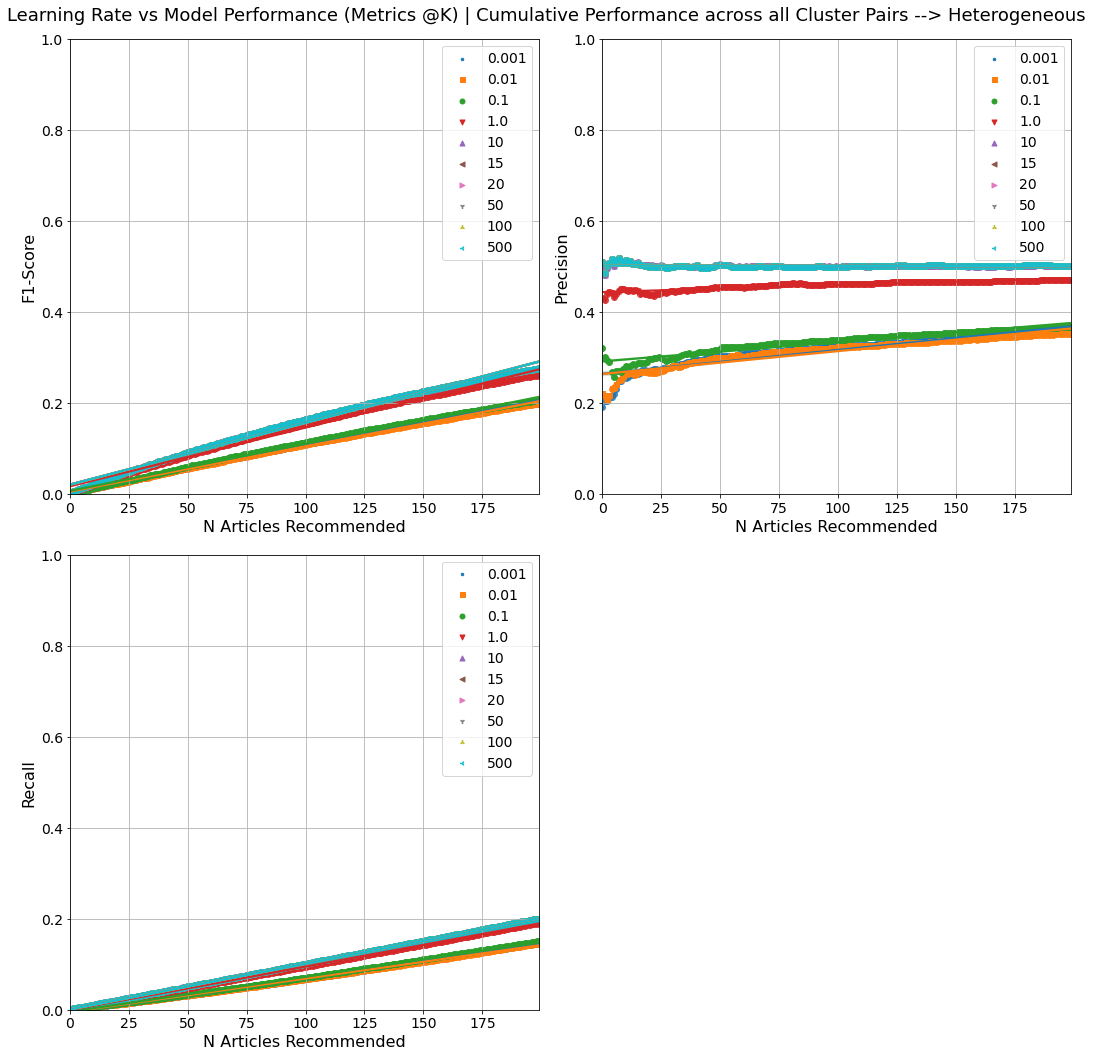


Finished running 'plot_lr_vs_metrics_at_k' in 0.0675 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0682 mins



In [47]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [48]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [49]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.6938904618171265

Param : 0.01
0.6946703961835345

Param : 0.1
0.668502152448777

Param : 1.0
0.5353418244592995

Param : 10
0.4974345055334703

Param : 15
0.4964461378724097

Param : 20
0.4964749867347208

Param : 50
0.4964749867347208

Param : 100
0.4964749867347208

Param : 500
0.4964749867347208


In [50]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [51]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.3160066340375502

Param : 0.01
0.31339091311016687

Param : 0.1
0.3333300523090111

Param : 1.0
0.45849659155130323

Param : 10
0.5006199792105649

Param : 15
0.5008430798870449

Param : 20
0.5008430798870449

Param : 50
0.5008430798870449

Param : 100
0.5008430798870449

Param : 500
0.5008430798870449


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [52]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [53]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [54]:
# homo_scores.keys()

In [55]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0003 mins


Finished running 'combine_scores_mixed_data' in 0.0001 mins



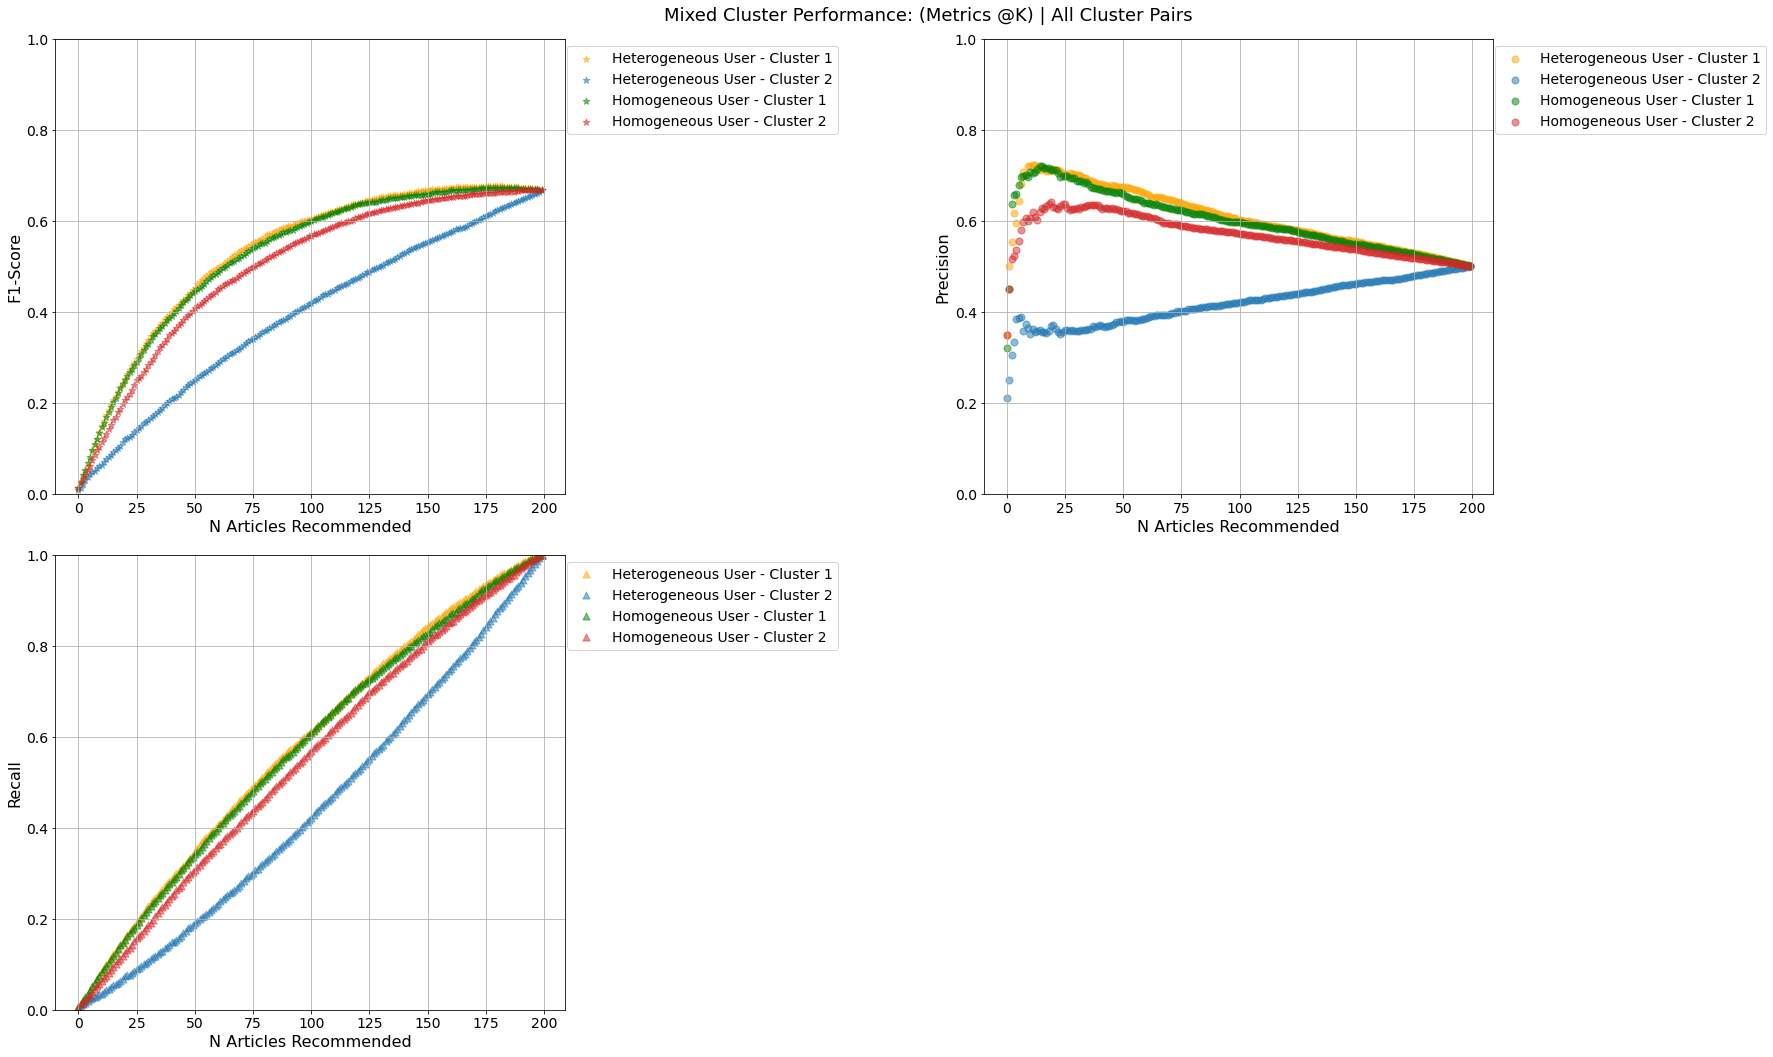


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0105 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0109 mins



In [56]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

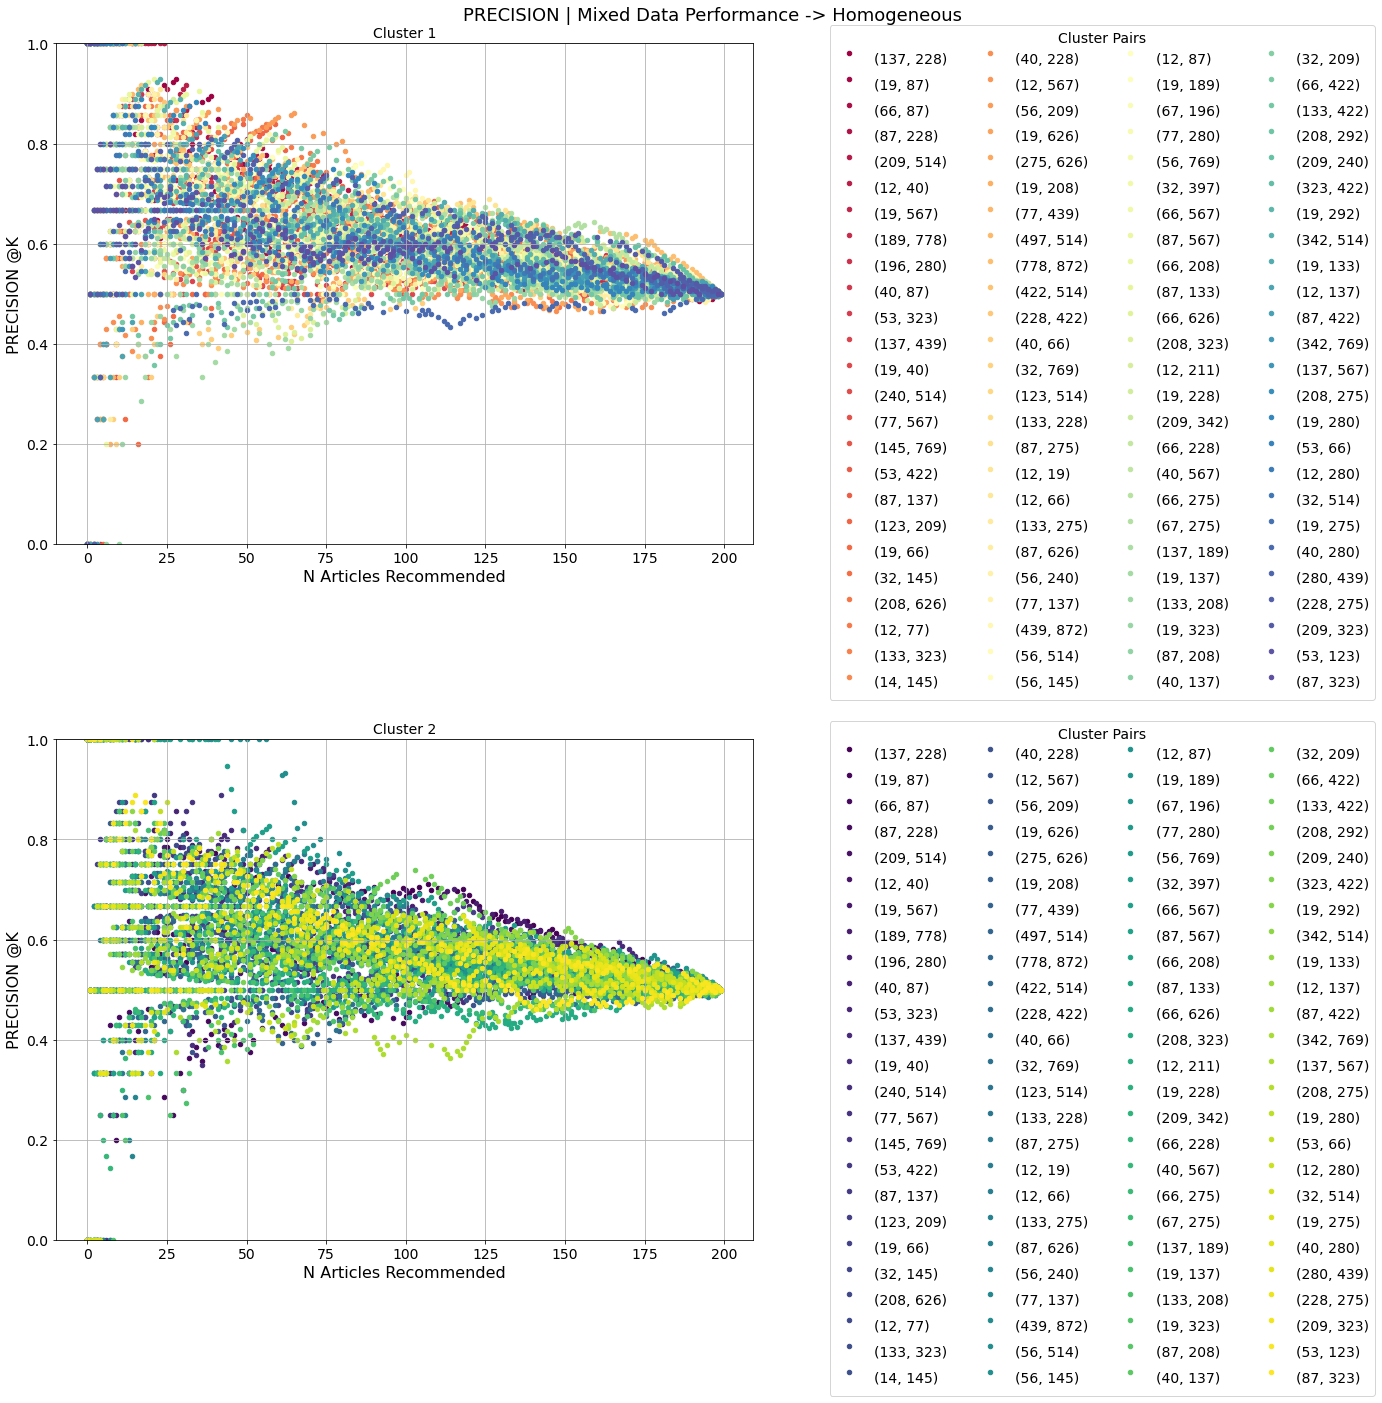


Finished running 'plot_mixed_data_all_cp_perf' in 0.1177 mins



In [57]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

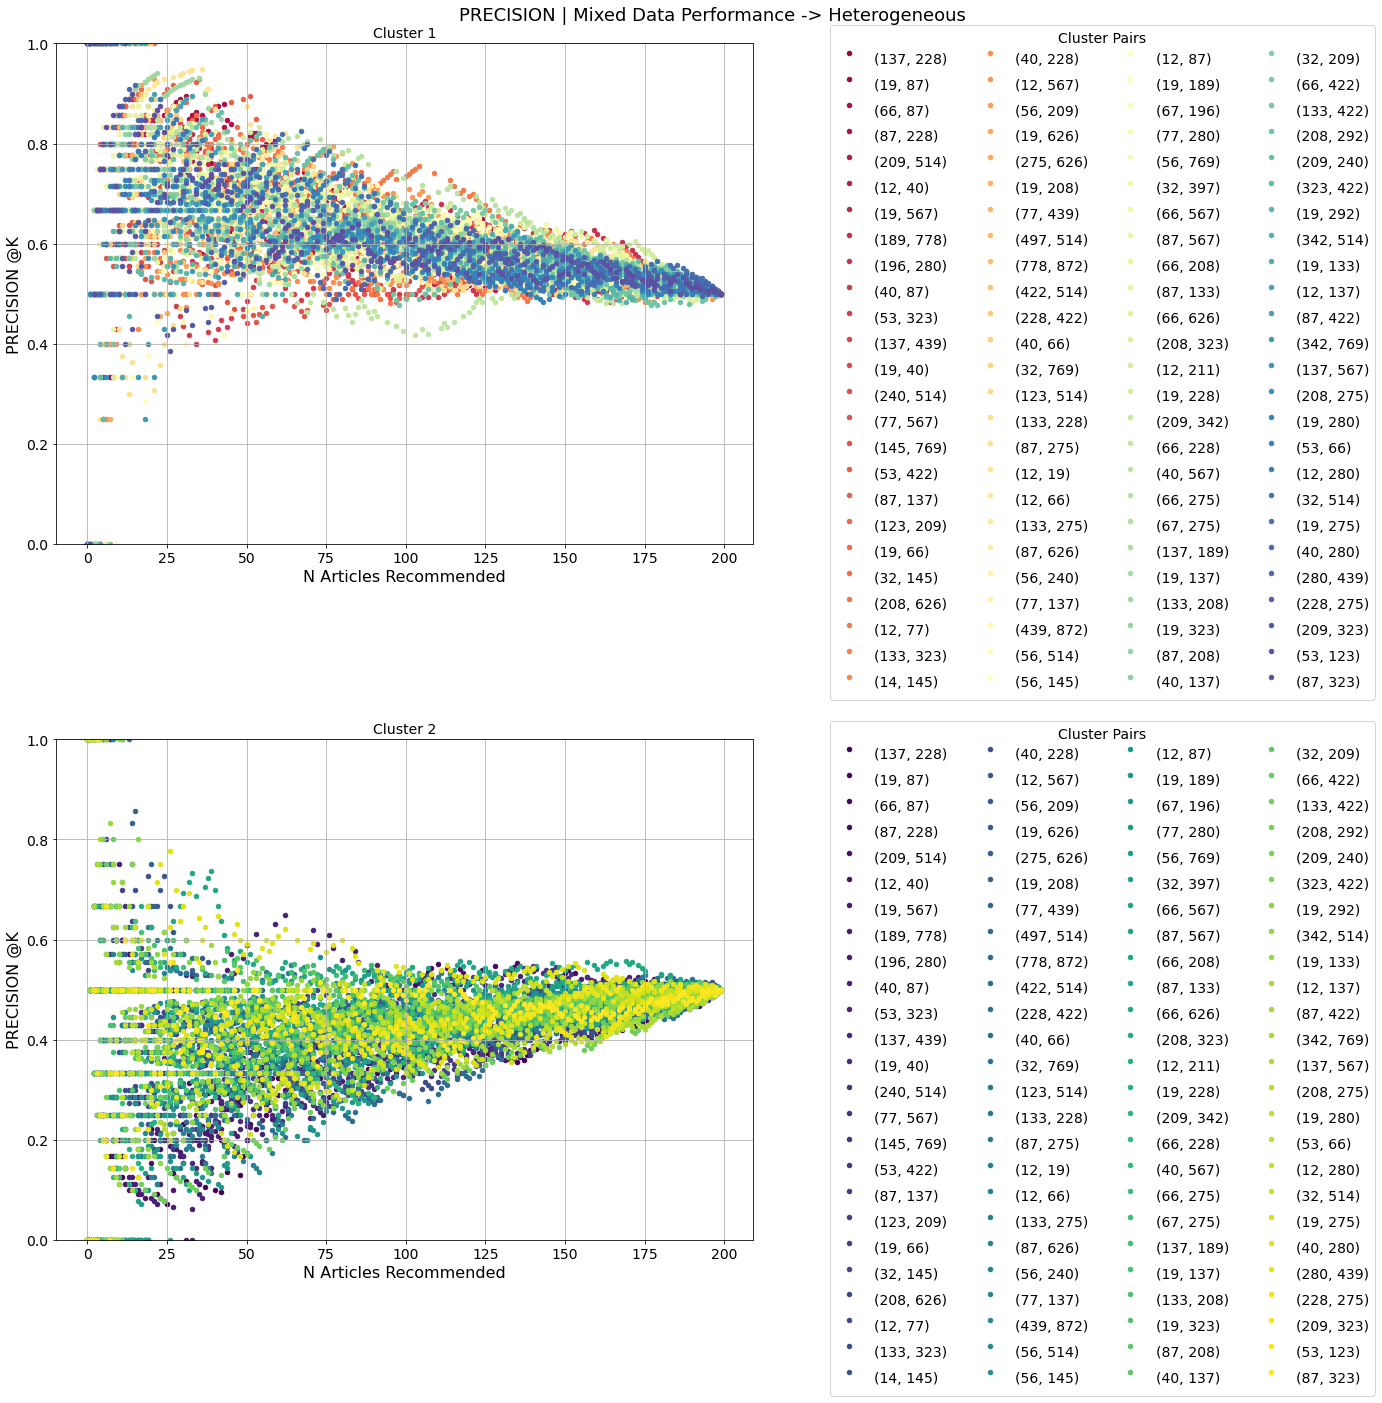


Finished running 'plot_mixed_data_all_cp_perf' in 0.1153 mins



In [58]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [59]:
avg_presc_homo,avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [60]:
np.mean(avg_presc_homo)

0.5867081094597993

In [61]:
np.mean(avg_presc_homo_c1)

0.5999958346603251

In [62]:
np.mean(avg_presc_homo_c2)

0.5685488568634426

In [63]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [64]:
np.mean(avg_presc_hetero)

0.5180206567468697

In [65]:
np.mean(avg_presc_hetero_c1)

0.6064691708081026

In [66]:
np.mean(avg_presc_hetero_c2)

0.4193503139701063

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [67]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [68]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [69]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [70]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



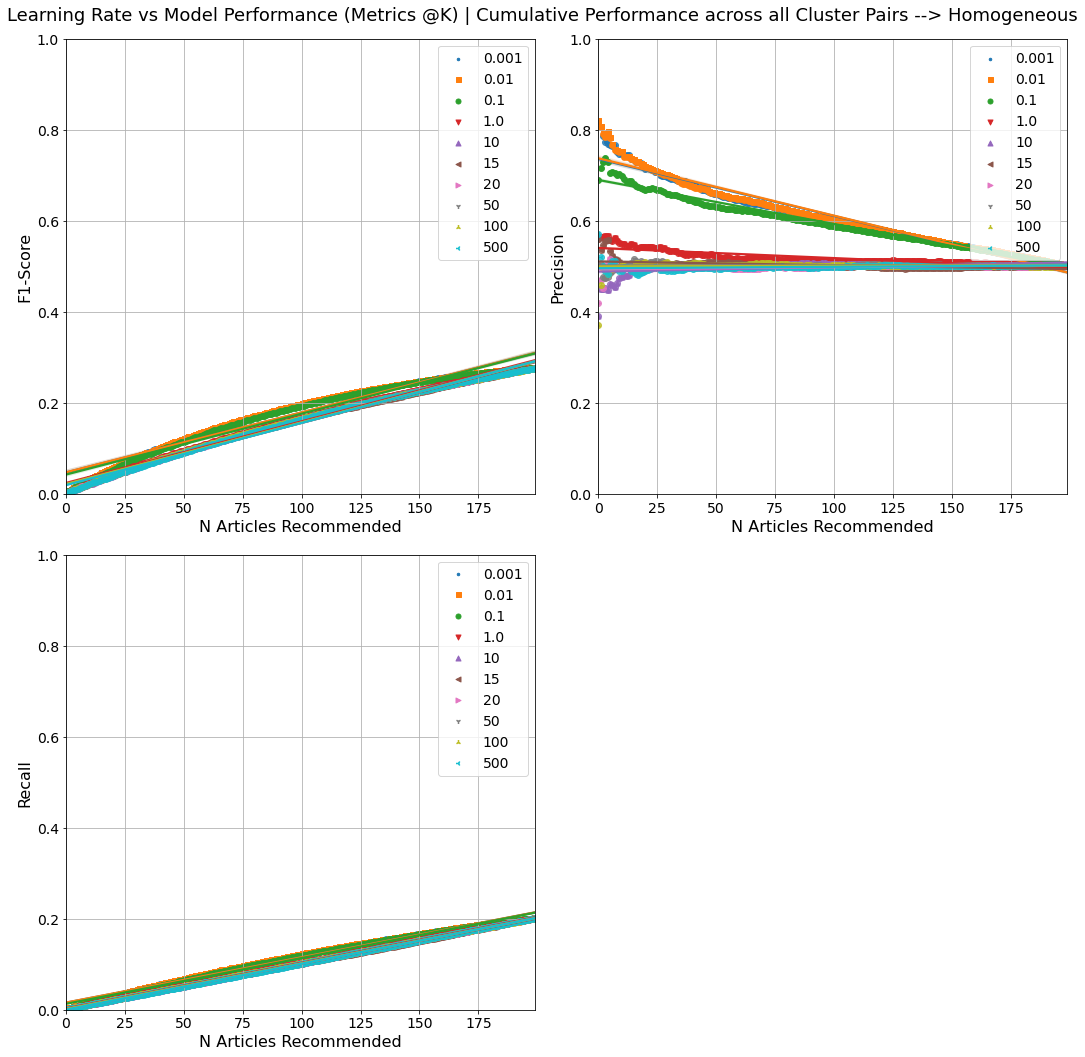


Finished running 'plot_lr_vs_metrics_at_k' in 0.0671 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0678 mins



In [71]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0008 mins



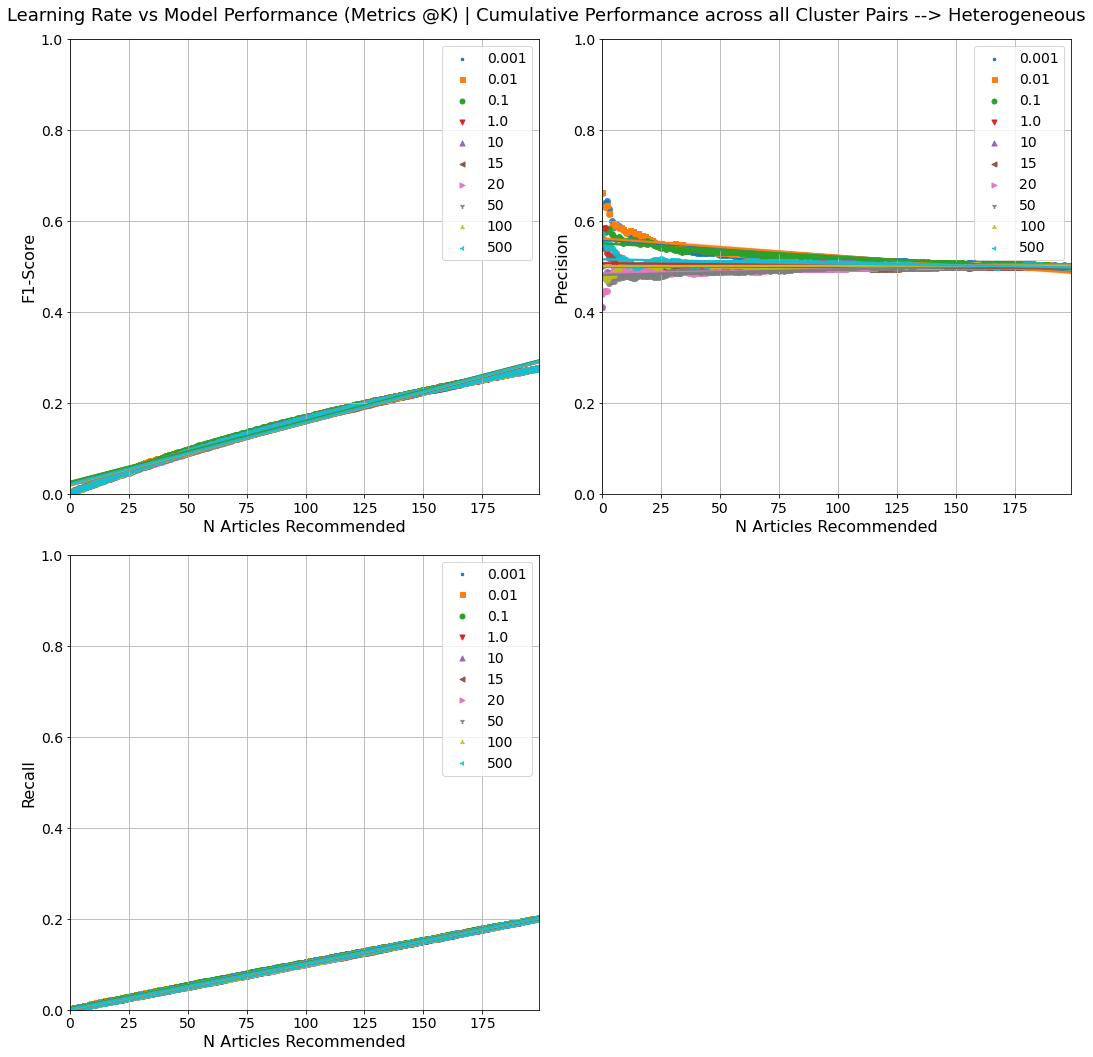


Finished running 'plot_lr_vs_metrics_at_k' in 0.0644 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0652 mins



In [72]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [73]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [74]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [75]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [76]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.6111331035746024
c1 MAP : 
0.6309217400854343
c2 MAP : 
0.5848044143608283

Param : 0.01
0.6118688475846473
c1 MAP : 
0.6320805666472669
c2 MAP : 
0.584066530575909

Param : 0.1
0.5933654493942888
c1 MAP : 
0.6086561619966626
c2 MAP : 
0.5698625581695774

Param : 1.0
0.5181018014432099
c1 MAP : 
0.5228263212870502
c2 MAP : 
0.5069092785704382

Param : 10
0.49839061581727095
c1 MAP : 
0.49755432104531716
c2 MAP : 
0.49477065389126623

Param : 15
0.5023039087455662
c1 MAP : 
0.49777891321642964
c2 MAP : 
0.5014234606885004

Param : 20
0.49800604887090616
c1 MAP : 
0.4958235557260331
c2 MAP : 
0.4936798957076975

Param : 50
0.5024365308219131
c1 MAP : 
0.5059702314075986
c2 MAP : 
0.49513042526548845

Param : 100
0.5008981775055188
c1 MAP : 
0.495628536767126
c2 MAP : 
0.5017264546417699

Param : 500
0.4988027106268699
c1 MAP : 
0.4949262260984046
c2 MAP : 
0.4950633457412028


In [77]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [78]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5229771409770617
c1 MAP : 
0.6248147049554
c2 MAP : 
0.3981187485004957

Param : 0.01
0.5235118125690128
c1 MAP : 
0.6249979686031683
c2 MAP : 
0.39641881242212823

Param : 0.1
0.5216718015004264
c1 MAP : 
0.6104470499856561
c2 MAP : 
0.4117612407424857

Param : 1.0
0.502153411044099
c1 MAP : 
0.5146057701166465
c2 MAP : 
0.4820098836460802

Param : 10
0.5015861273441087
c1 MAP : 
0.49491033611333785
c2 MAP : 
0.5044755590580584

Param : 15
0.49814173266450806
c1 MAP : 
0.49231916651317936
c2 MAP : 
0.498407785799241

Param : 20
0.49400485573902264
c1 MAP : 
0.5012871935753603
c2 MAP : 
0.4826613353943862

Param : 50
0.4929370949396571
c1 MAP : 
0.4962572519917551
c2 MAP : 
0.4860137819967802

Param : 100
0.5010021152225359
c1 MAP : 
0.49151705290718256
c2 MAP : 
0.5059343023149679

Param : 500
0.5063376351833725
c1 MAP : 
0.5032193021473881
c2 MAP : 
0.5041845041024556
